# Traffic Light Detection
With our dataset, we will be able to identify and classify traffic light signals.

# 1. Import Libraries and Load Data

First we will be importing the necessary dependencies for our project and loading in our dataset as well.


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import cv2
import random
import os
import pandas as pd
import sklearn
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Flatten
from tensorflow.keras.layers import Activation, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import warnings
import numpy as np  # linear algebra
%matplotlib inline

In [2]:
# Set data path for our dataset that we will be using
dataPath = 'C:/Users/Austin/HCL_TrafficLight/LISATrafficSet'

# Set path for our annotated training folders
dayTrainPath = dataPath + '/Annotations/Annotations/dayTrain'
nightTrainPath = dataPath + '/Annotations/Annotations/nightTrain'

### 1.1 Combining CSV Files
Because we have multiple CSV files from different folders, we will need to combine all of them and store them into a single dataframe to make things easier to work with. 

In [3]:
# Combine all the annotated files in all the Day Training folders
# and set 'dayTime' feature to 1 since all during day time

dayDirectory = sorted(os.listdir(dayTrainPath))
trainDayTime = []

for dayFileName in dayDirectory:
    if 'dayClip' in dayFileName:
        df = pd.read_csv(os.path.join(dayTrainPath,
                                      dayFileName,
                                      'frameAnnotationsBOX.csv'), sep=';')
        trainDayTime.append(df)
    else:
        continue
trainDayTime_df = pd.concat(trainDayTime, axis=0)

In [4]:
trainDayTime_df

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin file,Origin frame number,Origin track,Origin track frame number
0,dayTraining/dayClip1--00000.jpg,go,698,333,710,358,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0
1,dayTraining/dayClip1--00000.jpg,go,846,391,858,411,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0
2,dayTraining/dayClip1--00001.jpg,go,698,337,710,357,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1
3,dayTraining/dayClip1--00001.jpg,go,847,390,859,410,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1
4,dayTraining/dayClip1--00002.jpg,go,698,331,710,356,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,2,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,2
...,...,...,...,...,...,...,...,...,...,...
1935,dayTraining/dayClip9--00950.jpg,goLeft,971,174,1067,314,dayTraining/dayClip9/dayClip9Shutter0.000200-G...,950,dayTraining/dayClip9/dayClip9Shutter0.000200-G...,950
1936,dayTraining/dayClip9--00951.jpg,goLeft,1021,171,1099,306,dayTraining/dayClip9/dayClip9Shutter0.000200-G...,951,dayTraining/dayClip9/dayClip9Shutter0.000200-G...,951
1937,dayTraining/dayClip9--00953.jpg,warningLeft,1115,182,1199,299,dayTraining/dayClip9/dayClip9Shutter0.000200-G...,953,dayTraining/dayClip9/dayClip9Shutter0.000200-G...,953
1938,dayTraining/dayClip9--00954.jpg,warningLeft,1155,186,1260,294,dayTraining/dayClip9/dayClip9Shutter0.000200-G...,954,dayTraining/dayClip9/dayClip9Shutter0.000200-G...,954


In [5]:
# Combine all the annotated files in all the Night Training folders
# and set 'dayTime' feature to 0 since all during night time

nightDirectory = sorted(os.listdir(nightTrainPath))
trainNightTime = []

for nightFileName in nightDirectory:
    if 'nightClip' in nightFileName:
        df = pd.read_csv(os.path.join(nightTrainPath,
                                      nightFileName,
                                      'frameAnnotationsBOX.csv'), sep=';')
        trainNightTime.append(df)
    else:
        continue
trainNightTime_df = pd.concat(trainNightTime, axis=0)

In [6]:
#Check to make sure that 'dayTime' is set to 0 since night time dataset
trainNightTime_df

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin file,Origin frame number,Origin track,Origin track frame number
0,nightTraining/nightClip1--00000.jpg,go,650,280,669,319,nightTraining/nightClip1/clip1.mp4,0,nightTraining/nightClip1/clip1.mp4,0
1,nightTraining/nightClip1--00000.jpg,go,709,286,730,322,nightTraining/nightClip1/clip1.mp4,0,nightTraining/nightClip1/clip1.mp4,0
2,nightTraining/nightClip1--00000.jpg,go,803,332,822,371,nightTraining/nightClip1/clip1.mp4,0,nightTraining/nightClip1/clip1.mp4,0
3,nightTraining/nightClip1--00000.jpg,go,687,347,699,371,nightTraining/nightClip1/clip1.mp4,0,nightTraining/nightClip1/clip1.mp4,0
4,nightTraining/nightClip1--00000.jpg,go,708,347,720,371,nightTraining/nightClip1/clip1.mp4,0,nightTraining/nightClip1/clip1.mp4,0
...,...,...,...,...,...,...,...,...,...,...
3231,nightTraining/nightClip5--01450.jpg,go,937,221,976,290,nightTraining/nightClip5/clip5.mp4,1450,nightTraining/nightClip5/clip5.mp4,1450
3232,nightTraining/nightClip5--01451.jpg,go,467,36,512,117,nightTraining/nightClip5/clip5.mp4,1451,nightTraining/nightClip5/clip5.mp4,1451
3233,nightTraining/nightClip5--01451.jpg,go,937,219,976,288,nightTraining/nightClip5/clip5.mp4,1451,nightTraining/nightClip5/clip5.mp4,1451
3234,nightTraining/nightClip5--01452.jpg,go,460,33,506,114,nightTraining/nightClip5/clip5.mp4,1452,nightTraining/nightClip5/clip5.mp4,1452


In [7]:
# Now that we have all of the day and night annotations combined respectively, we will combine
# the two into create one large dataset
combined_df = pd.concat([trainDayTime_df, trainNightTime_df], axis=0)

# 2. Data Preprocessing

We will begin removing and adjusting our data and our columns to fit our needs. We first check for any missing data, then we observe to see if there are any unnecessary data in our dataframe that needs to be removed. We will then adjust the labeling of our columns to make things easier to work with down the line.


In [8]:
# Checking to see if we have any missing values in our dataset
combined_df.isnull().sum()

Filename                     0
Annotation tag               0
Upper left corner X          0
Upper left corner Y          0
Lower right corner X         0
Lower right corner Y         0
Origin file                  0
Origin frame number          0
Origin track                 0
Origin track frame number    0
dtype: int64

###  2.1 Remove unnecessary columns from data. 
Four columns have duplicate information that we do not need for our project so we remove them to simplify our data.

In [9]:
# Four of the columns in our dataframe appear to have the same values, we are checking here to confirm that they are the same
print(df['Origin file'].equals(df['Origin track']))
print(df['Origin frame number'].equals(df['Origin track frame number']))

True
True


In [10]:
# Since they are the same values and they have no value to us, we can drop the duplicate columns
combined_df = combined_df.drop(['Origin file',
                                'Origin track',
                                'Origin frame number',
                                'Origin track frame number'], axis=1)

In [11]:
combined_df.columns = ['frame', 'signal', 'left_x', 'left_y','right_x','right_y']
combined_df.head()

,frame,signal,left_x,left_y,right_x,right_y
0,dayTraining/dayClip1--00000.jpg,go,698,333,710,358
1,dayTraining/dayClip1--00000.jpg,go,846,391,858,411
2,dayTraining/dayClip1--00001.jpg,go,698,337,710,357
3,dayTraining/dayClip1--00001.jpg,go,847,390,859,410
4,dayTraining/dayClip1--00002.jpg,go,698,331,710,356


### 2.2 Label Encoding
We need to change signal from string to an integer because our model requires our classes to be an integer.

In [12]:
# Change signal string to an integer
def tagToLabel(tag):
    if tag == '1':
        return 'go'
    if tag == '2':
        return 'warning'
    if tag == '3':
        return 'stop'
    elif tag == '0':
        return None


def changeSignal(rowLabel):
    if rowLabel == 'go' or rowLabel == 'goLeft':
        return '1'
    elif rowLabel == 'warning' or rowLabel == 'warningLeft':
        return '2'
    elif rowLabel == 'stop' or rowLabel == 'stopLeft':
        return '3'
    else:
        return '0'


combined_df['signal'] = combined_df['signal'].apply(changeSignal)
combined_df

,frame,signal,left_x,left_y,right_x,right_y
0,dayTraining/dayClip1--00000.jpg,1,698,333,710,358
1,dayTraining/dayClip1--00000.jpg,1,846,391,858,411
2,dayTraining/dayClip1--00001.jpg,1,698,337,710,357
3,dayTraining/dayClip1--00001.jpg,1,847,390,859,410
4,dayTraining/dayClip1--00002.jpg,1,698,331,710,356
...,...,...,...,...,...,...
3231,nightTraining/nightClip5--01450.jpg,1,937,221,976,290
3232,nightTraining/nightClip5--01451.jpg,1,467,36,512,117
3233,nightTraining/nightClip5--01451.jpg,1,937,219,976,288
3234,nightTraining/nightClip5--01452.jpg,1,460,33,506,114


In [13]:
sorted(combined_df['signal'].unique())

['1', '2', '3']

### 2.3 Update Frame File path
Need to update the frame name to correct file path so we can find the actual image.

In [14]:
# Need to change the id name to fit clip name in datasets
# dayTraining/dayClip1--00000.jpg ----> C:\Users\Austin\HCL_TrafficLight\LISATrafficSet\dayTrain\dayTrain\dayClip1\frames\dayClip1--00000

def updateName(fileName):

    # First we have to parse id to obtain which clip folder and which specific frame
    folder, frameName = fileName.split('/')
    frameDir, clipId = frameName.split('--')
    if folder == 'dayTraining':
        newFileName = dataPath + '/dayTrain/dayTrain/{0}/frames/{1}'.format(frameDir, frameName)
    else:
        newFileName = dataPath + '/nightTrain/nightTrain/{0}/frames/{1}'.format(frameDir, frameName)
    return newFileName

In [15]:
combined_df['frame']= combined_df.frame.apply(updateName)
combined_df.head()

,frame,signal,left_x,left_y,right_x,right_y
0,C:/Users/Austin/HCL_TrafficLight/LISATrafficSe...,1,698,333,710,358
1,C:/Users/Austin/HCL_TrafficLight/LISATrafficSe...,1,846,391,858,411
2,C:/Users/Austin/HCL_TrafficLight/LISATrafficSe...,1,698,337,710,357
3,C:/Users/Austin/HCL_TrafficLight/LISATrafficSe...,1,847,390,859,410
4,C:/Users/Austin/HCL_TrafficLight/LISATrafficSe...,1,698,331,710,356


In [16]:
combined_df.to_csv(r'C:\Users\Austin\HCL_TrafficLight\cleanedData\recentData.csv')

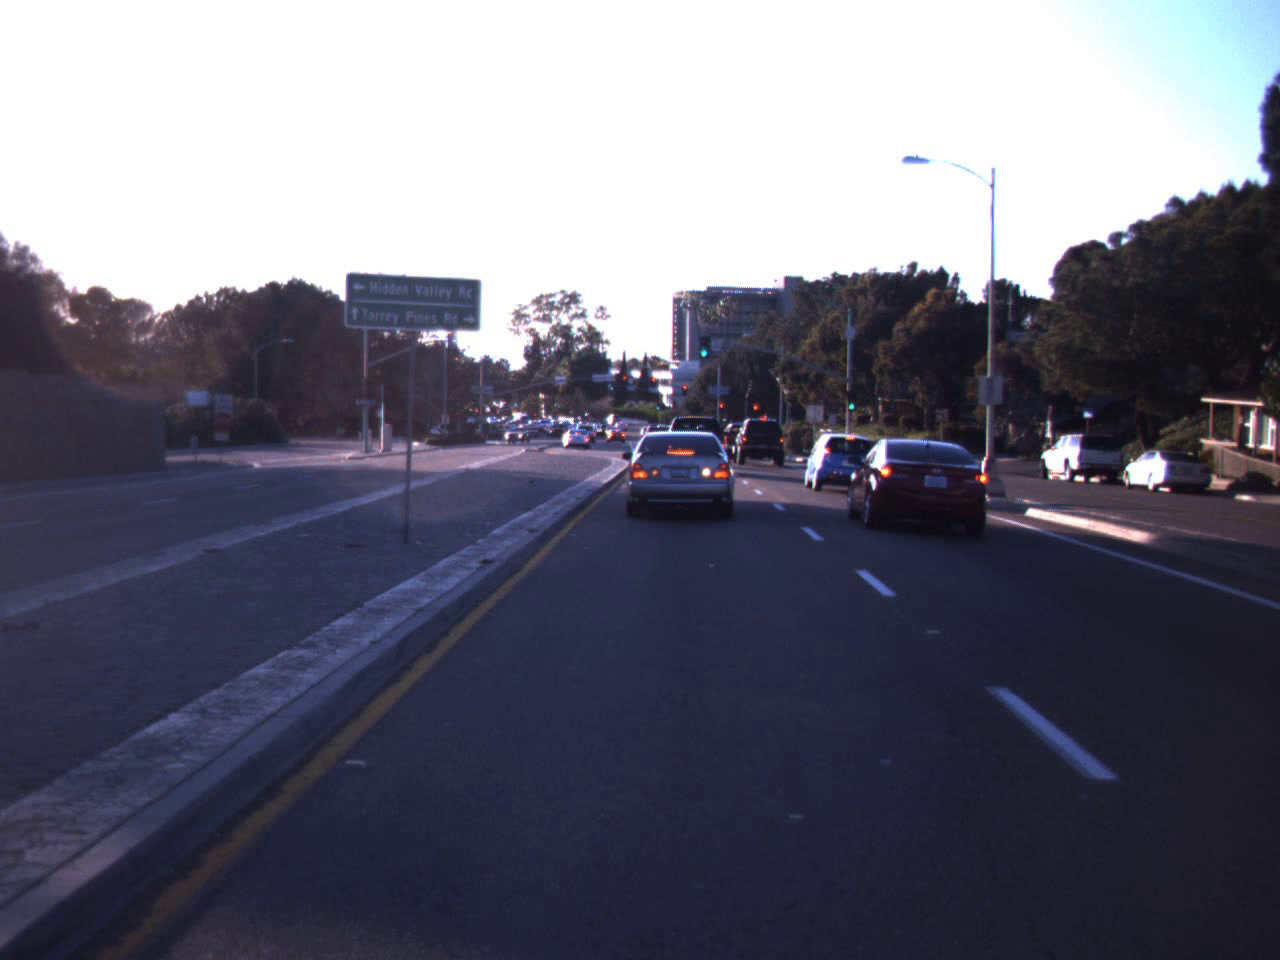

In [17]:
from IPython.display import display
testImage = combined_df['frame'].iloc[0]
display(Image.open(testImage))

### 2.4 Quick Image Test
Here we are just quickly checking to make sure that the image and labels are correct. We randomly take an image from each class and annotate them.

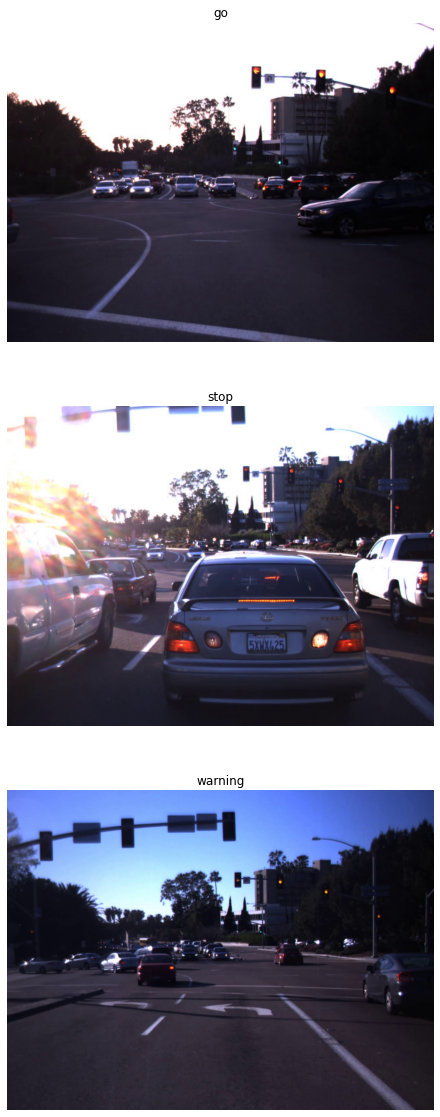

In [18]:
# Creating 3 subplots for each of the classes
fig, ax = plt.subplots(3, 1, figsize=(20, 20))
annoTags = combined_df['signal'].unique()

for i, tag in enumerate(annoTags):
    #  Take random sample from dataset to annotate
    sample = combined_df[combined_df['signal'] == tag].sample(1)

    #  Change color of image to fit RGB color space
    image = cv2.imread(sample.frame.values[0])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ax[i].set_title(tagToLabel(tag))
    ax[i].set_axis_off()
    ax[i].imshow(image)

### 2.5 Split Files into Test and Train Dataframes
We created our own split function to split the data based on the unique folders we have. This is so that sequential frames are not in seperate dataframes.

In [19]:
# Need to identify the folder that the clip is in
# C:\Users\Austin\HCL_TrafficLight\LISATrafficSet\dayTrain\dayTrain\ {dayClip1} \frames\dayClip1--00000

def nameSplit(frameId):
    clipName = frameId.split('/')[7]
    return clipName


combined_df['clipNames'] = sorted(combined_df['frame'].apply(nameSplit))
combined_df['clipNames'].unique()

array(['dayClip1', 'dayClip10', 'dayClip11', 'dayClip12', 'dayClip13',
       'dayClip2', 'dayClip3', 'dayClip4', 'dayClip5', 'dayClip6',
       'dayClip7', 'dayClip8', 'dayClip9', 'nightClip1', 'nightClip2',
       'nightClip3', 'nightClip4', 'nightClip5'], dtype=object)

In [36]:
# We need to split our dataframe into test and training sets
def splitTestTrain(df):
    clipNames = combined_df['clipNames'].unique()
    nightClips = []
    dayClips = []

    # Seperate data by the 'day' and 'night' folders
    for name in clipNames:
        if 'day' in name:
            dayClips.append(name)
        else:
            nightClips.append(name)

    # Select random clip names from day and night folders to use for test set
    testNightClipNames = random.choices(nightClips, k=int(len(nightClips)*0.25))
    testDayClipNames = random.choices(dayClips, k=int(len(dayClips)*0.25))
    testClipNames = testDayClipNames + testNightClipNames

    train_df = combined_df[~combined_df['clipNames'].isin(testClipNames)]
    test_df = combined_df[combined_df['clipNames'].isin(testClipNames)]

    return train_df, test_df

In [37]:
train_df, test_df = splitTestTrain(combined_df)

In [38]:
test_df['clipNames'].unique()

array(['dayClip2', 'dayClip7', 'dayClip8', 'nightClip1'], dtype=object)

In [39]:
train_df.shape[0]/combined_df.shape[0]

0.7302796528447445

# 3. Model 
After our data preprocessing, we decided to use a pre-trained model from TensorFlow Keras. The model that we have selected we the VGG16 model since this what was given and shown during the learning phase.

In [40]:
tf.config.optimizer.set_jit(True) #optimizing for cpu

In [41]:
warnings.filterwarnings("ignore")

# Can change 'input_shape' to lower values to lower resolution, and possibly speed up training
base_model = VGG16(input_shape=(112, 112, 3), # Lower image quality to improve training time
                   include_top=False,  # Leave out last fully connected layer
                   weights='imagenet')  # Use ImageNet pre-trained weights

# Since we don't need to train all layers, we make them non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Build our own last fully connected layer. First we flatten all of the previous layers, then we add two Dense layers to
# increase complexity to allow our model to develop better features. Lastly, we include our last Dense layer that condenses
# our model into one of our classes.
x = base_model.output
x = Flatten()(x)
# x = Dense(64, activation = 'relu')(x)
# x = Dense(64, activation = 'relu')(x)
x = Dense(40, activation='relu')(x)
x = Dense(40, activation='relu')(x)
x = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

# Because there are multiple classes, we use 'sparse_categorical_crossentropy' for our loss. We chose 'adam' as our
# optimizer since it was often times recommended in our Kaggle courses.
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print("model compiles")

model compiles


In [42]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 112, 112, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 112, 112, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 56, 56, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 56, 56, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 56, 56, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 28, 28, 128)      

# 4. Training
After selecting the model, we can begin training our model. 

In [43]:
X = train_df
y = X['signal']
print(y.shape, X.shape)

(37865,) (37865, 7)


### 4.1 Train and Validation Set
We first split our train data into train and validation before testing.

In [44]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=2)

In [45]:
targetSize = (112, 112)
batchSize = 32

# Apply any data-augmentation here. Using ImageDataGenrator(), we rescale our input to be between 0 and 1, but RGB is from
# 0-255 which is why we rescale image to 1/255.
tdatagen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                             rescale=1./255,
                             rotation_range = 40,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             horizontal_flip = True)

vdatagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                              rescale=1./255)

# We feed our X_train and X_val sets into the function flow_from_dataframe() so we can create batches of images.
# We also adjust the image size with the parameter target_size (can help reduce traiing time).
trainDatagen = tdatagen.flow_from_dataframe(
    dataframe=X_train,
    directory=None,
    x_col="frame",
    y_col="signal",
    batch_size=batchSize,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=targetSize
)

valDatagen = vdatagen.flow_from_dataframe(
    dataframe=X_val,
    directory=None,
    x_col="frame",
    y_col="signal",
    batch_size=batchSize,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=targetSize
)

Found 30290 validated image filenames belonging to 3 classes.
Found 7573 validated image filenames belonging to 3 classes.


In [46]:
# Here we are training our model by inputing our batches of images. We determine the numbers of steps within an epoch and
# how many epochs we would like to go through.
history = model.fit(trainDatagen,
                    steps_per_epoch=X_train.shape[0]//batchSize,
                    epochs=8,
                    validation_data=valDatagen,
                    validation_steps=X_val.shape[0]//batchSize)

Epoch 1/8
946/946 [==============================] - 1268s 1s/step - loss: 0.5678 - accuracy: 0.7402 - val_loss: 0.4542 - val_accuracy: 0.8169
Epoch 2/8
946/946 [==============================] - 1186s 1s/step - loss: 0.4425 - accuracy: 0.8086 - val_loss: 0.4016 - val_accuracy: 0.8420
Epoch 3/8
946/946 [==============================] - 1128s 1s/step - loss: 0.4030 - accuracy: 0.8270 - val_loss: 0.4151 - val_accuracy: 0.8235
Epoch 4/8
946/946 [==============================] - 1169s 1s/step - loss: 0.3774 - accuracy: 0.8397 - val_loss: 0.5190 - val_accuracy: 0.7914
Epoch 5/8
946/946 [==============================] - 1111s 1s/step - loss: 0.3604 - accuracy: 0.8473 - val_loss: 0.3724 - val_accuracy: 0.8402
Epoch 6/8
946/946 [==============================] - 1131s 1s/step - loss: 0.3413 - accuracy: 0.8539 - val_loss: 0.3883 - val_accuracy: 0.8236
Epoch 7/8
946/946 [==============================] - 1084s 1s/step - loss: 0.3401 - accuracy: 0.8537 - val_loss: 0.2989 - val_accuracy: 0.8700

In [47]:
model.save("testVG16v14.h5")

### 4.2 Evaluate Our Model

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


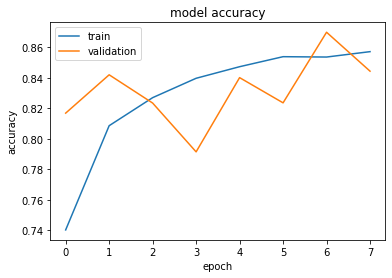

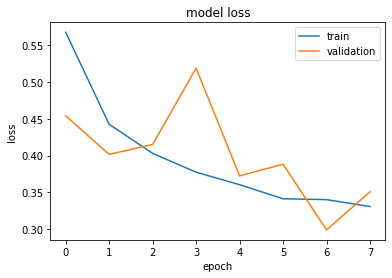

In [48]:
print(history.history.keys())

#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

### 4.3 Bonus Model: InceptionV3 Model


In [49]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
base_modelv3 = InceptionV3(input_shape=(112, 112, 3),
                           include_top=False,
                           weights='imagenet')

for layer in base_modelv3.layers:
    layer.trainable = False

x = Flatten()(base_modelv3.output)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(3, activation='softmax')(x)

model_2 = tf.keras.models.Model(base_modelv3.input, x)

model_2.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

print("model compiles")

model compiles


In [50]:
inc_history = model_2.fit(trainDatagen,
                        steps_per_epoch=X_train.shape[0]//32,
                        epochs=8,
                        validation_data=valDatagen,
                        validation_steps = X_val.shape[0]//32)

Epoch 1/8
946/946 [==============================] - 511s 540ms/step - loss: 0.7077 - accuracy: 0.6837 - val_loss: 0.5680 - val_accuracy: 0.7386
Epoch 2/8
946/946 [==============================] - 507s 535ms/step - loss: 0.5333 - accuracy: 0.7571 - val_loss: 0.5927 - val_accuracy: 0.7117
Epoch 3/8
946/946 [==============================] - 508s 537ms/step - loss: 0.4857 - accuracy: 0.7823 - val_loss: 0.4773 - val_accuracy: 0.7921
Epoch 4/8
946/946 [==============================] - 511s 540ms/step - loss: 0.4615 - accuracy: 0.7917 - val_loss: 0.4338 - val_accuracy: 0.8068
Epoch 5/8
946/946 [==============================] - 511s 540ms/step - loss: 0.4431 - accuracy: 0.8026 - val_loss: 0.4325 - val_accuracy: 0.8122
Epoch 6/8
946/946 [==============================] - 507s 536ms/step - loss: 0.4336 - accuracy: 0.8086 - val_loss: 0.3793 - val_accuracy: 0.8248
Epoch 7/8
946/946 [==============================] - 512s 541ms/step - loss: 0.4240 - accuracy: 0.8112 - val_loss: 0.3704 - val_ac

In [51]:
model_2.save("testIncV2.h5")

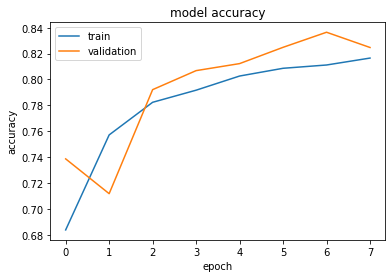

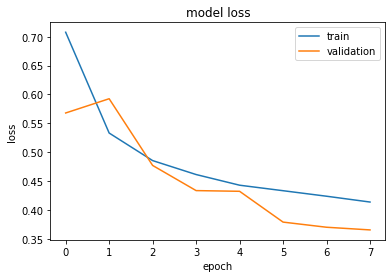

In [52]:
#  "Accuracy"
plt.plot(inc_history.history['accuracy'])
plt.plot(inc_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

# "Loss"
plt.plot(inc_history.history['loss'])
plt.plot(inc_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

### 4.4 Bonus Model: ResNet50 Model 

In [53]:
from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras import layers

base_model50 = ResNet50(input_shape=(112, 112, 3),
                        include_top=False,
                        weights="imagenet")

for layer in base_model50.layers:
    layer.trainable = False

x = base_model50.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(3, activation='softmax')(x)

model_3 = tf.keras.models.Model(base_model50.input, x)

model_3.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [55]:
resnet_history = model_3.fit(trainDatagen,
                             steps_per_epoch=X_train.shape[0]//batchSize,
                             epochs=8,
                             validation_data=valDatagen,
                             validation_steps=X_val.shape[0]//batchSize)

Epoch 1/8
946/946 [==============================] - 716s 757ms/step - loss: 0.6945 - accuracy: 0.6610 - val_loss: 0.6185 - val_accuracy: 0.7210
Epoch 2/8
946/946 [==============================] - 718s 759ms/step - loss: 0.6761 - accuracy: 0.6711 - val_loss: 0.6310 - val_accuracy: 0.6796
Epoch 3/8
946/946 [==============================] - 743s 785ms/step - loss: 0.6510 - accuracy: 0.6889 - val_loss: 0.6011 - val_accuracy: 0.7131
Epoch 4/8
946/946 [==============================] - 765s 809ms/step - loss: 0.6472 - accuracy: 0.6906 - val_loss: 0.6346 - val_accuracy: 0.6958
Epoch 5/8
946/946 [==============================] - 762s 806ms/step - loss: 0.6432 - accuracy: 0.6923 - val_loss: 0.6054 - val_accuracy: 0.7268
Epoch 6/8
946/946 [==============================] - 829s 876ms/step - loss: 0.6270 - accuracy: 0.7024 - val_loss: 0.7304 - val_accuracy: 0.6323
Epoch 7/8
946/946 [==============================] - 861s 910ms/step - loss: 0.6200 - accuracy: 0.7083 - val_loss: 0.5829 - val_ac

In [57]:
model_3.save("testResNet2.h5")

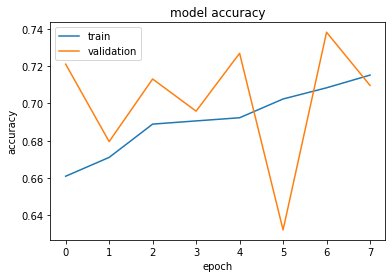

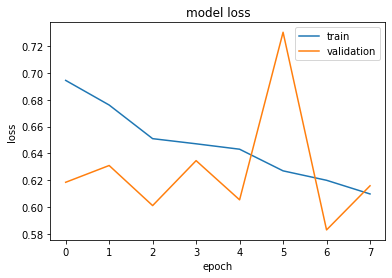

In [58]:
#  "Accuracy"
plt.plot(resnet_history.history['accuracy'])
plt.plot(resnet_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

# "Loss"
plt.plot(resnet_history.history['loss'])
plt.plot(resnet_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()